In [464]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from utils.data_utils import *
from utils.model_utils import *
from utils.insert_shapelet import multiple_insert_shapelet

from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


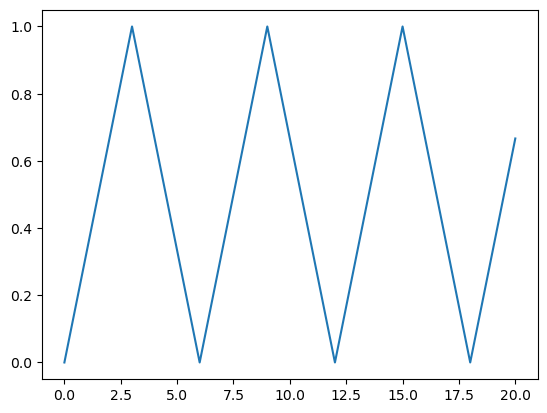

In [416]:
def create_1d_zigzag_array(seq_len, cycle_len):
    """
    Generate a zigzag pattern for a sequence.
    
    Parameters:
        seq_len (int): Total sequence length.
        cycle_len (int): Length of one zigzag cycle (up and down).
    
    Returns:
        np.ndarray: An array containing the zigzag pattern.
    """
    # Ensure cycle_len is at least 2 to create a zigzag pattern
    if cycle_len < 2:
        raise ValueError("cycle_len must be at least 2.")
    
    # Generate one cycle of the zigzag (up and down)
    half_cycle = cycle_len // 2
    upward = np.arange(half_cycle) / half_cycle  # e.g., [0, 1, 2, ...]
    downward = np.arange(half_cycle, 0, -1)  / half_cycle  # e.g., [2, 1]
    full_cycle = np.concatenate((upward, downward[:cycle_len - len(upward)]))
    
    # Tile the cycles to cover the full sequence length
    num_repeats = (seq_len + len(full_cycle) - 1) // len(full_cycle)
    zigzag = np.tile(full_cycle, num_repeats)[:seq_len]
    
    return zigzag

# Example: create a zigzag array of size 10
zigzag_array = create_1d_zigzag_array(21, 7)
plt.plot(zigzag_array)

In [436]:
# def s1():
#     return np.concatenate((np.arange(-0.5,0.5,0.1),np.arange(0.5,-0.6,-0.1)))
# def s2():
#     return np.concatenate((np.arange(0.5,-0.5,-0.1),np.arange(-0.5,0.6,0.1)))
# def s3():
#     return np.array([0.5]*21)
# def s4():
#     return np.array([-0.5]*21)

s1 = np.concatenate((np.arange(-0.5,0.5,0.2),np.arange(0.5,-0.6,-0.2)))+0.5
s2 = np.concatenate((np.arange(0.5,-0.5,-0.2),np.arange(-0.5,0.6,0.2)))
s3 = np.array([0.5]*11)
s4 = np.array([-0.5]*11)
s5 = np.arange(-0.5,0.6,0.1)+0.5
s6 = np.arange(0.5,-0.6,-0.1)+0.5
s7 = np.sin(np.linspace(0,2*np.pi,21)) + np.sin(np.linspace(0,4*np.pi,21))
s8 = np.cos(np.linspace(0,2*np.pi,21)) + np.cos(np.linspace(0,4*np.pi,21))
s9 = create_1d_zigzag_array(21, 7)*4-2



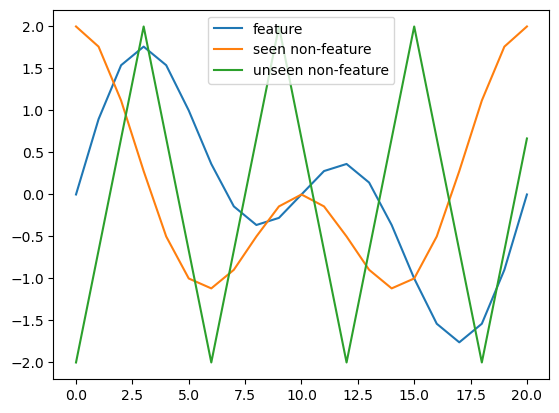

In [419]:
# plt.plot(s1,label='s1')
# plt.plot(s2,label='s2')
# plt.plot(s3,label='s3')
# plt.plot(s4,label='s4')
# plt.plot(s5,label='s5')
# plt.plot(s6,label='s6')
plt.plot(s7,label='feature')
plt.plot(s8,label='seen non-feature')
plt.plot(s9,label='unseen non-feature')
plt.legend()

In [420]:
def data_shaplet(shapelets,mean = 0,input_length=150, shapelet_length=21,std_dev = 0.01,num = 500):

    c = np.zeros((num,1,input_length))
    num_shapelet = len(shapelets)
    for i in range(num):

        a = np.zeros(input_length) 

        instance_startings = multiple_insert_shapelet(input_length, num_shapelet, shapelet_length)
        
        starting = np.random.randint(input_length-shapelet_length)
        for j in range(num_shapelet):
            starting = instance_startings[j]
            shapelet = shapelets[j]
            a[starting:starting + shapelet_length] = shapelet
        a = a + np.random.normal(mean, std_dev, a.shape)
        c[i] = a.reshape(1,input_length)
    return c #z_normalization(c)

In [421]:

input_length= 100
shapelet_length=21
std_dev = 0.02
num = 100


In [422]:
# data generation
def data_generation():
    c0_1 = data_shaplet([s7,s8], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    c0_2 = data_shaplet([s7], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c0_3 = data_shaplet([s1,s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c0_4 = data_shaplet([s1], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    
    c1_1 = data_shaplet([s8], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    c1_2 = data_shaplet([], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c1_3 = data_shaplet([s6], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    # c1_4 = data_shaplet([], input_length=input_length, shapelet_length=shapelet_length,std_dev = std_dev,num = num)
    

    return np.concatenate([c0_1,c0_2,c1_1,c1_2]), np.concatenate([[0]*200,[1]*200])
train_x, train_y = data_generation()
test_x, test_y = data_generation()

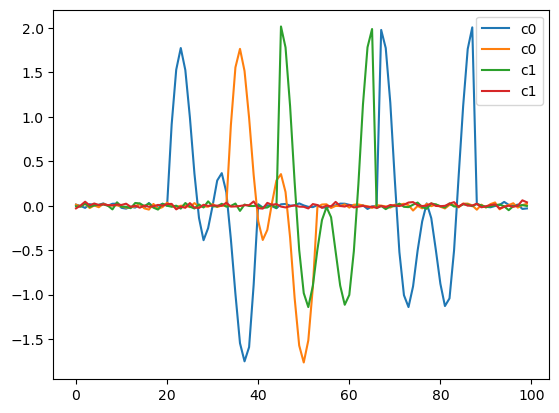

In [426]:
plt.plot(train_x[0].flatten(),label='c0')
plt.plot(train_x[100].flatten(),label='c0')
plt.plot(train_x[200].flatten(),label='c1')
plt.plot(train_x[300].flatten(),label='c1')
plt.legend()

In [424]:
enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

model_dataset_path = 'models/simu5'

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [425]:
model = FCN(c_in=1, c_out=2)
train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=500)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)


train_preds, ground_truth = get_all_preds(model, train_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
# np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, train_preds)
print(f'acc:{acc:.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 87.26it/s]

acc:1.000
acc:1.000


In [348]:
# same shape different location
# simu 4
# def data_diff_loc(shapelet,starting,mean = 0,input_length=150, shapelet_length=21,std_dev = 0.01, num = 500):

#     c = np.zeros((num,1,input_length))
#     for i in range(num):
        
#         a = np.zeros(input_length) 
#         a[starting:starting + shapelet_length] = shapelet
#         a = a + np.random.normal(mean, std_dev, a.shape)
#         c[i] = a.reshape(1,input_length)
#     return z_normalization(c)
# c0_0_diff_loc = data_diff_loc(s1 + 0.5,20, shapelet_length=11,num =15)
# c0_1_diff_loc = data_diff_loc(s1 + 0.5,100, shapelet_length=11,num =15)
# c1_1_diff_loc = data_diff_loc(s1 + 0.5,60, shapelet_length=11,num =30)
# train_x, train_y = np.concatenate([c0_0_diff_loc,c0_1_diff_loc,c1_1_diff_loc]), np.concatenate([[0]*30,[1]*30])

# c0_0_diff_loc = data_diff_loc(s1 + 0.5,20, shapelet_length=11,num =15)
# c0_1_diff_loc = data_diff_loc(s1 + 0.5,100, shapelet_length=11,num =15)
# c1_1_diff_loc = data_diff_loc(s1 + 0.5,60, shapelet_length=11,num =30)
# test_x, test_y = np.concatenate([c0_0_diff_loc,c0_1_diff_loc,c1_1_diff_loc]), np.concatenate([[0]*30,[1]*30])

In [330]:
print(c0_0_diff_loc.shape, c0_0_diff_loc.shape, c1_1_diff_loc.shape, train_x.shape)

(15, 1, 150) (15, 1, 150) (30, 1, 150) (60, 1, 150)


In [331]:
enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

model_dataset_path = 'models/simu4'

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)


In [ ]:
for i in range(30):
    plt.plot(train_x[i].flatten(), alpha=0.5, c='blue')
    plt.plot(train_x[-i].flatten(), alpha=0.5, c='orange', label='class 1')

In [332]:
from tsai.models.MLP import MLP
model =  MLP(c_in=1, c_out=2,seq_len=150)

(60, 1, 150) (60, 2) (60, 1, 150) (60, 2)


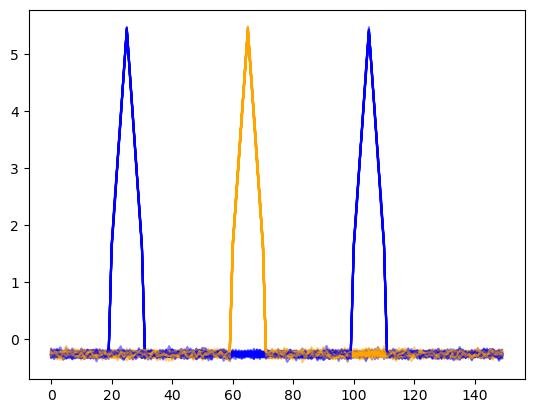

In [283]:
for i in range(30):
    plt.plot(train_x[i].flatten(), alpha=0.5, c='blue')
    plt.plot(train_x[-i].flatten(), alpha=0.5, c='orange', label='class 1')

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

In [284]:
train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=200)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 503.71it/s]


acc:1.000


In [156]:
train_preds, ground_truth = get_all_preds(model, train_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
# np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, train_preds)
print(f'acc:{acc:.3f}')

acc:1.000


In [446]:
# simu 6
def data_diff_loc(shapelet,starting_mean, starting_std, mean = 0,input_length=150, shapelet_length=21,std_dev = 0.01, num = 500):

    c = np.zeros((num,1,input_length))
    startings = []
    for i in range(num):
        starting=-1
        while starting<0 or starting+shapelet_length>=input_length:
            starting = int(np.random.normal(starting_mean, starting_std))
        startings.append(starting)

            
        a = np.zeros(input_length) 
        a[starting:starting + shapelet_length] = shapelet
        a = a + np.random.normal(mean, std_dev, a.shape)
        c[i] = a.reshape(1,input_length)
    return z_normalization(c), startings


c0_diff_loc, st0 = data_diff_loc(s1,30, 20, shapelet_length=11,num =50)
c1_diff_loc, st1 = data_diff_loc(s1,90, 20, shapelet_length=11,num =50)


train_x, train_y = np.concatenate([c0_diff_loc,c1_diff_loc]), np.concatenate([[0]*50,[1]*50])

c0_diff_loc, st0 = data_diff_loc(s1,30, 30, shapelet_length=11,num =50)
c1_diff_loc, st1 = data_diff_loc(s1,90, 30, shapelet_length=11,num =50)
test_x, test_y = np.concatenate([c0_diff_loc,c1_diff_loc]), np.concatenate([[0]*50,[1]*50])

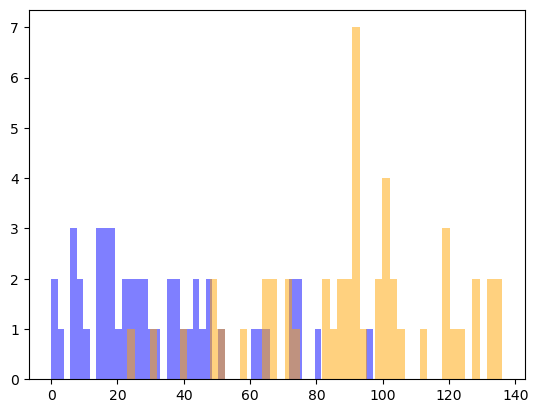

In [447]:
plt.hist(st0, bins=50, color='blue', alpha=0.5)
plt.hist(st1, bins=50, color='orange', alpha=0.5)
plt.show()

In [448]:




enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

model_dataset_path = 'models/simu6'

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [449]:
from tsai.models.MLP import MLP

In [450]:
model = MLP(c_in=1,c_out=2,seq_len=150)
train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=200)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 450.45it/s]

acc:0.820


# train a dataset with inserted datasets

In [453]:
import utils
from utils.insert_shapelet import get_pdata

In [468]:
selected_training = [
    "ACSF1",
    "StandWalkJump",
    "NonInvasiveFetalECGThorax2",
    "Adiac",
    "ArrowHead",
    "BeetleFly",
    "Phoneme",
    "UWaveGestureLibraryZ",
    "UWaveGestureLibraryY",
    "Lightning2",
    "Coffee",
    "TwoLeadECG",
    "WormsTwoClass",
    "CricketY",
    "Meat",
    "BirdChicken",
    "FaceFour",
    "ECGFiveDays",
    "Worms",
    "StarLightCurves",
]

In [477]:
shapelet = s7
instance_length = 150
pdata_dict = get_pdata(shapelet=shapelet, selected_datasets=selected_training, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                   is_z_norm=True, 
                   is_blending=False, blend_length=5,
                   is_best_insert=True,
                   save_dir='models/simu7/')

dealing with ACSF1: (100, 1, 1460)
dealing with StandWalkJump: (12, 4, 2500)
dealing with NonInvasiveFetalECGThorax2: (1800, 1, 750)
dealing with Adiac: (390, 1, 176)
dealing with ArrowHead: (36, 1, 251)
dealing with BeetleFly: (20, 1, 512)
dealing with Phoneme: (214, 1, 1024)
dealing with UWaveGestureLibraryZ: (896, 1, 315)
dealing with UWaveGestureLibraryY: (896, 1, 315)
dealing with Lightning2: (60, 1, 637)
dealing with Coffee: (28, 1, 286)
dealing with TwoLeadECG: (23, 1, 82)
dealing with WormsTwoClass: (181, 1, 900)
dealing with CricketY: (390, 1, 300)
dealing with Meat: (60, 1, 448)
dealing with BirdChicken: (20, 1, 512)
dealing with FaceFour: (24, 1, 350)
dealing with ECGFiveDays: (23, 1, 136)
dealing with Worms: (181, 1, 900)
dealing with StarLightCurves: (1000, 1, 1024)


In [478]:
pdata_dict['pdata_ws'].shape

(1342, 1, 150)

In [479]:
pdata = np.concatenate((pdata_dict['pdata_ws'],pdata_dict['pdata_wos']),axis=0)
pdata_s_label = np.array([0]*1342+[1]*1342)
pdata.shape

(2684, 1, 150)

In [480]:
train_x, test_x, train_y, test_y = train_test_split(
    pdata, pdata_s_label, test_size=0.2, random_state=42)

enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

model_dataset_path = 'models/simu7'

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [481]:
model = FCN(c_in=1,c_out=2)
train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=200)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.47it/s]

acc:0.993
